# Classroom Scheduling Efficiency Analysis

## Context
A university is questioning the efficiency of its scheduling process:
- Students complain about inconvenient schedules
- The scheduling team says there's too little space
- The real estate team claims there's too much space

As part of an IoT project, we collected occupancy data for approximately 15 rooms across multiple buildings.

## Questions to Address:
1. **Are the rooms fully scheduled?**
2. **Is there a lack of space to schedule new classes?**
3. **Are classes scheduled in appropriate locations (e.g., room size vs. class size)?**

## Setup and Data Loading

In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Load and prepare data
df = pd.read_csv('OccupancyCleaned.csv')

# Convert date columns
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

# Create derived columns
df['occupancy_rate'] = (df['occupancy'] / df['capacity'] * 100).round(1)
df['duration'] = (df['end'] - df['start']).dt.total_seconds() / 3600
df['date'] = df['start'].dt.date
df['hour'] = df['start'].dt.hour
df['day'] = df['start'].dt.day_name()

# Display basic information
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Number of unique rooms: {df['roomName'].nunique()}")
print(f"Number of unique courses: {df['courseCode'].nunique()}")
df.head()

Dataset Overview:
Shape: (1490, 15)
Number of unique rooms: 11
Number of unique courses: 277


,lectureId,courseCode,roomName,buildingName,start,end,capacity,expectedGroupSize,occupancy,status,occupancy_rate,duration,date,hour,day
0,959640,CC2005_2025,M1-17,Building 3,2025-09-01 09:00:00,2025-09-01 10:45:00,145,139.0,33.0,Completed,22.8,1.75,2025-09-01,9,Monday
1,959642,FEB61000_2025,CB-1,Building 2,2025-09-01 09:00:00,2025-09-01 10:45:00,482,400.0,379.0,Completed,78.6,1.75,2025-09-01,9,Monday
2,959643,FEB61000_2025,CB-4,Building 2,2025-09-01 09:00:00,2025-09-01 10:45:00,118,100.0,94.0,Completed,79.7,1.75,2025-09-01,9,Monday
3,959645,FEB61000_2025,L0.03,Building 1,2025-09-01 09:00:00,2025-09-01 10:45:00,256,250.0,227.0,Completed,88.7,1.75,2025-09-01,9,Monday
4,959681,CM1015_2025,CB-5,Building 2,2025-09-01 09:00:00,2025-09-01 10:45:00,308,300.0,236.0,Completed,76.6,1.75,2025-09-01,9,Monday


## Question 1: Are the rooms fully scheduled?

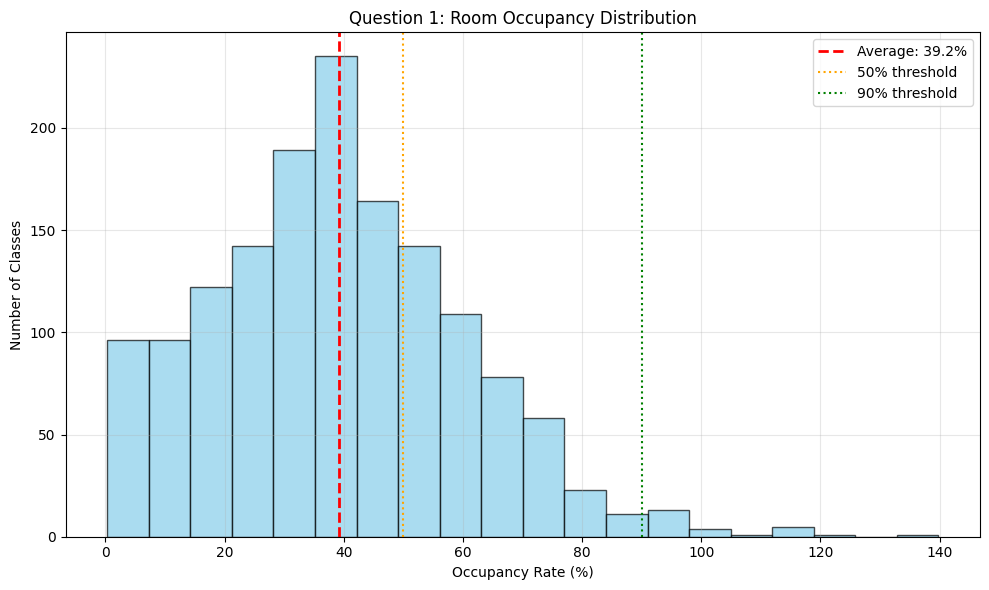

QUESTION 1: Are the rooms fully scheduled?

Total classes analyzed: 1490
Total unique rooms: 11
- Average occupancy rate: 39.2%
- Classes with <50% occupancy: 71.1% (1059 classes)
- Classes with >90% occupancy: 1.7% (25 classes)

Additional Insights:
- Most utilized room: M1-19 (45.4% occupancy)
- Least utilized room: CB-5 (35.1% occupancy)


In [49]:
# Calculate metrics
total_classes = len(df)
total_rooms = df['roomName'].nunique()
avg_occupancy_rate = df['occupancy_rate'].mean()
rooms_under_50 = (df['occupancy_rate'] < 50).sum() / total_classes * 100
rooms_over_90 = (df['occupancy_rate'] > 90).sum() / total_classes * 100

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df['occupancy_rate'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
ax.axvline(avg_occupancy_rate, color='red', linestyle='--', linewidth=2, 
           label=f'Average: {avg_occupancy_rate:.1f}%')
ax.axvline(50, color='orange', linestyle=':', linewidth=1.5, 
           label='50% threshold')
ax.axvline(90, color='green', linestyle=':', linewidth=1.5, 
           label='90% threshold')
ax.set_xlabel('Occupancy Rate (%)')
ax.set_ylabel('Number of Classes')
ax.set_title('Question 1: Room Occupancy Distribution')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print results
print("QUESTION 1: Are the rooms fully scheduled?")
print(f"\nTotal classes analyzed: {total_classes}")
print(f"Total unique rooms: {total_rooms}")
print(f"- Average occupancy rate: {avg_occupancy_rate:.1f}%")
print(f"- Classes with <50% occupancy: {rooms_under_50:.1f}% ({int(rooms_under_50/100*total_classes)} classes)")
print(f"- Classes with >90% occupancy: {rooms_over_90:.1f}% ({int(rooms_over_90/100*total_classes)} classes)")

# Additional insights
print("\nAdditional Insights:")
room_util = df.groupby('roomName')['occupancy_rate'].mean().sort_values(ascending=False)
print(f"- Most utilized room: {room_util.index[0]} ({room_util.iloc[0]:.1f}% occupancy)")
print(f"- Least utilized room: {room_util.index[-1]} ({room_util.iloc[-1]:.1f}% occupancy)")

## Question 2: Is there a lack of space to schedule new classes?

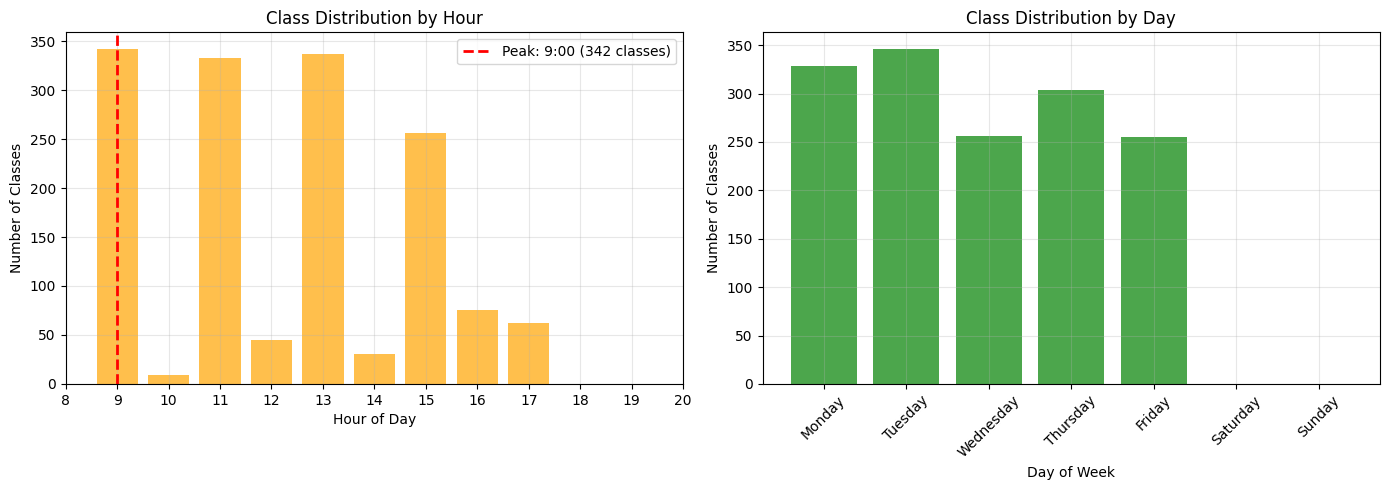

QUESTION 2: Is there a lack of space to schedule new classes?
- Peak hour: 9:00 (342 classes)
- Unique rooms used at peak: 11 out of 11
- Peak hour room utilization: 100.0%
- Average classes per day: 33.9
- Busiest day: Tuesday (346 classes)
- Quietest day: Saturday (0 classes)


In [50]:
# Calculate metrics
hourly_usage = df.groupby('hour').size()
peak_hour = hourly_usage.idxmax()
peak_usage = hourly_usage.max()
avg_daily_classes = df.groupby('date').size().mean()

# Calculate peak hour utilization
peak_hour_classes = df[df['hour'] == peak_hour]
unique_rooms_at_peak = peak_hour_classes['roomName'].nunique()
peak_utilization_rate = (unique_rooms_at_peak / total_rooms) * 100

# Day of week analysis
day_counts = df['day'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order, fill_value=0)
busiest_day = day_counts.idxmax()
busiest_day_count = day_counts.max()
quietest_day = day_counts.idxmin()
quietest_day_count = day_counts.min()

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Hourly usage
ax1.bar(hourly_usage.index, hourly_usage.values, color='orange', alpha=0.7)
ax1.axvline(peak_hour, color='red', linestyle='--', linewidth=2, 
            label=f'Peak: {peak_hour}:00 ({peak_usage} classes)')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Classes')
ax1.set_title('Class Distribution by Hour')
ax1.set_xticks(range(8, 21))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Daily usage
ax2.bar(day_counts.index, day_counts.values, color='green', alpha=0.7)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Classes')
ax2.set_title('Class Distribution by Day')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results
print("QUESTION 2: Is there a lack of space to schedule new classes?")
print(f"- Peak hour: {peak_hour}:00 ({peak_usage} classes)")
print(f"- Unique rooms used at peak: {unique_rooms_at_peak} out of {total_rooms}")
print(f"- Peak hour room utilization: {peak_utilization_rate:.1f}%")
print(f"- Average classes per day: {avg_daily_classes:.1f}")
print(f"- Busiest day: {busiest_day} ({busiest_day_count} classes)")
print(f"- Quietest day: {quietest_day} ({quietest_day_count} classes)")

## Question 3: Are classes scheduled in appropriate locations?

C:\Users\apaul\AppData\Local\Temp\ipykernel_14300\2149893338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_size['size_match'] = np.where(


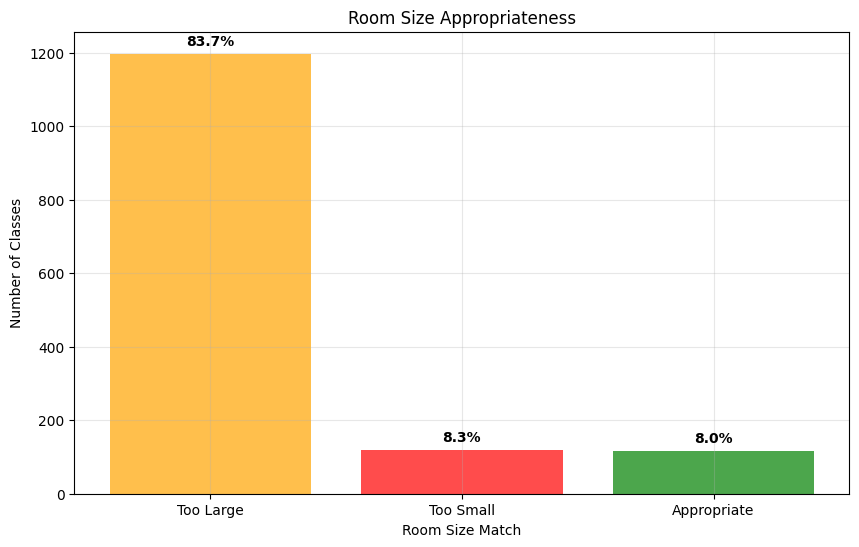

QUESTION 3: Are classes scheduled in appropriate locations?

• Classes with expected group size data: 1430 (96.0% of all classes)

Size Appropriateness Results:
  - Too Large: 83.7% (1197 classes)
  - Too Small: 8.3% (118 classes)
  - Appropriate: 8.0% (115 classes)

Additional Insights:

Examples of rooms that are TOO SMALL:
  - CB-4: Expected 120 students, Capacity 118 (Deficit: 2 seats)
  - M1-17: Expected 150 students, Capacity 145 (Deficit: 5 seats)
  - CT-1: Expected 200 students, Capacity 139 (Deficit: 61 seats)

Examples of rooms that are TOO LARGE:
  - M1-17: Expected 139 students, Capacity 145 (Excess: 6 seats)
  - CB-5: Expected 300 students, Capacity 308 (Excess: 8 seats)
  - M1-19: Expected 130 students, Capacity 145 (Excess: 15 seats)


In [52]:
df_with_size = df[df['expectedGroupSize'].notna() & (df['expectedGroupSize'] > 0)]

# Check if we have expected group size data
if len(df_with_size) > 0:
    # Create size match categories
    df_with_size['size_match'] = np.where(
        df_with_size['occupancy'] / df_with_size['expectedGroupSize'] > 0.8,
        'Appropriate',
        np.where(df_with_size['capacity'] < df_with_size['expectedGroupSize'], 'Too Small', 'Too Large')
    )
    
    # Calculate metrics
    size_match_stats = df_with_size['size_match'].value_counts(normalize=True) * 100
    appropriate_rate = size_match_stats.get('Appropriate', 0)
    
    # Visualization
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    size_counts = df_with_size['size_match'].value_counts()
    colors = {'Appropriate': 'green', 'Too Small': 'red', 'Too Large': 'orange'}
    color_list = [colors[cat] for cat in size_counts.index]
    
    ax1.bar(size_counts.index, size_counts.values, color=color_list, alpha=0.7)
    ax1.set_xlabel('Room Size Match')
    ax1.set_ylabel('Number of Classes')
    ax1.set_title('Room Size Appropriateness')
    
    # Add percentage labels
    total = len(df_with_size)
    for i, (match_type, count) in enumerate(size_counts.items()):
        percentage = count/total*100
        ax1.text(i, count + max(size_counts.values)*0.02, 
                f'{percentage:.1f}%', ha='center', fontweight='bold')
    ax1.grid(True, alpha=0.3)    
    
    plt.show()
    
    # Print results
    print("QUESTION 3: Are classes scheduled in appropriate locations?")
    print(f"\n• Classes with expected group size data: {len(df_with_size)} ({len(df_with_size)/total_classes*100:.1f}% of all classes)")
    print("\nSize Appropriateness Results:")
    for match_type, percentage in size_match_stats.items():
        count = int(percentage/100 * len(df_with_size))
        print(f"  - {match_type}: {percentage:.1f}% ({count} classes)")
    
    # Additional insights
    print("\nAdditional Insights:")
    # Find examples of poor matches
    too_small_examples = df_with_size[df_with_size['size_match'] == 'Too Small'].head(3)
    too_large_examples = df_with_size[df_with_size['size_match'] == 'Too Large'].head(3)
    
    if len(too_small_examples) > 0:
        print("\nExamples of rooms that are TOO SMALL:")
        for idx, row in too_small_examples.iterrows():
            print(f"  - {row['roomName']}: Expected {row['expectedGroupSize']:.0f} students, "
                  f"Capacity {row['capacity']:.0f} (Deficit: {row['expectedGroupSize'] - row['capacity']:.0f} seats)")
    
    if len(too_large_examples) > 0:
        print("\nExamples of rooms that are TOO LARGE:")
        for idx, row in too_large_examples.iterrows():
            print(f"  - {row['roomName']}: Expected {row['expectedGroupSize']:.0f} students, "
                  f"Capacity {row['capacity']:.0f} (Excess: {row['capacity'] - row['expectedGroupSize']:.0f} seats)")
    
else:
    print("QUESTION 3: Are classes scheduled in appropriate locations?")
    print("\nNo expected group size data available for analysis.")
    print(f"Only {len(df_with_size)} out of {total_classes} classes have expected group size information.")

## Summary findings

1. Room Scheduling: Rooms are underutilized (39.2% average occupancy)

2. Space Availability: Near total room utilization at peak (100.0%)

3. Room Appropriateness: Many classes in poorly sized rooms (83.7% are scheduled in too large rooms, only 8% are fitted in right rooms)